In [1]:
import seaborn as sns
import os
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torchvision
from sklearn.metrics import roc_curve,auc, precision_score,precision_recall_curve,recall_score,precision_recall_fscore_support,confusion_matrix
import numpy as np
from prettytable import PrettyTable
print(torch.cuda.is_available())
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
print(torch.cuda.get_device_properties(0).total_memory)
print(torch.cuda.memory_allocated())
gpu_id = 2

True
11721506816
0


In [9]:
!nvidia-smi

Mon Jul 19 19:03:03 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 440.82       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:04:00.0 Off |                  N/A |
| 20%   26C    P8     8W / 250W |     10MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:06:00.0 Off |                  N/A |
| 20%   24C    P8     7W / 250W |     10MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [10]:
my_path = '../../dataset/sharma_59_nih_dataset/Image_dataset/'
path_0 = my_path+'0_0/'
path_1 = my_path + '1_1/'
print(len(os.listdir(path_0)))
print(len(os.listdir(path_1)))


# torchvision.transforms.Normalize(mean=torch.rand(3),std = torch.rand(3))
transformations = torchvision.transforms.Compose([torchvision.transforms.Resize((256,256)),
                                                  torchvision.transforms.CenterCrop(224),
                                                  torchvision.transforms.ToTensor()])

images = torchvision.datasets.ImageFolder(root=my_path,transform=transformations)
train_data,validate_data,test_data = torch.utils.data.dataset.random_split(images,[8020,2286,1146])
train_loader = torch.utils.data.DataLoader(dataset=train_data,batch_size=64,shuffle=True)
validate_loader = torch.utils.data.DataLoader(dataset = validate_data,batch_size=64,shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_data,batch_size=64,shuffle=True)


print(images.class_to_idx)

5727
5725
{'0_0': 0, '1_1': 1}


torch.Size([64, 3, 224, 224])
tensor(1.)


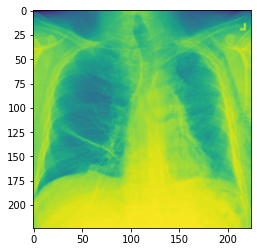

In [11]:
image,label = next(iter(train_loader))
print(image.shape)

print(torch.max(image))
plt.imshow(image[0][0])

In [12]:
class Model_class(object):

    def __init__(self,py_model,gpu_id=2):
        self.model = py_model
        self.fpr = {}
        self.tpr = {}
        self.auc_ = {}

        self.best_valid_acc = 0.65
        self.best_model = None
        self.best_optimizer = None

        self.val_acc = []
        self.train_acc = []
        self.val_loss = []
        self.train_loss = []

        self.gpu_id=gpu_id
        self.model = self.model.cuda(self.gpu_id)
        

    def train(self,train_loader,optimizer,Losses_,lr,n_epochs,validate_loader,schedular,regularization = 'None'):
        weight_decay = 0.0001
        self.n_epochs = n_epochs
        
        for epochs in range(n_epochs):
            batch_loss = []
            batch_acc = [] 
            val_batch_loss= []
            val_batch_acc = []
            for idx , (data,target) in enumerate(train_loader):


                """ mean normalization """
                data = self.Normalize_train(data)
                
                data = data.cuda(self.gpu_id)
                target = target.cuda(self.gpu_id)
                
                scores = self.model(data)
                
                reg_loss = 0
                if (regularization == 'l1'):
                    for params in self.model.parameters():
                        reg_loss += torch.sum(abs(params))

                if (regularization == 'l2'):
                    for params in self.model.parameters():
                        reg_loss += torch.norm(params)
                    
                loss = Losses_(scores,target) + weight_decay * reg_loss
                batch_loss.append(float(loss))

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                batch_accuracy = self.evaluate_batch(data,target)
                batch_acc.append(float(batch_accuracy))
                
            self.model.eval()

            for idx ,(data,target) in enumerate(validate_loader):

                data = self.Normalize(data)

                data = data.cuda(self.gpu_id)
                target = target.cuda(self.gpu_id)

                scores = self.model(data)
                loss = Losses_(scores,target)
                val_batch_loss.append(float(loss))

                batch_accuracy = self.evaluate_batch(data,target)
                val_batch_acc.append(float(batch_accuracy))

            self.model.train()

            occupied_memory = torch.cuda.memory_allocated(self.gpu_id)/(1024*1024*1024)
            total_memory = torch.cuda.get_device_properties(self.gpu_id).total_memory/(1024*1024*1024)

            self.train_loss.append(batch_loss)
            self.train_acc.append(batch_acc)
            self.val_loss.append(val_batch_loss)
            self.val_acc.append(val_batch_acc)

            valid_acc = np.mean(val_batch_acc)
            if(valid_acc > self.best_valid_acc):
                print("one of the best validation acc found")
                self.best_valid_acc = valid_acc
                self.best_model = copy.deepcopy(self.model.state_dict())  
                self.best_optimizer = copy.deepcopy(optimizer.state_dict())
            
            schedular.step()

            print(f'epoch:[{epochs+1}/{n_epochs}],memory:[{occupied_memory}/{total_memory}], lr:[{optimizer.param_groups[0]["lr"]}]') 
            print(f'train_accuracy:{np.mean(batch_acc)}, train_loss:{np.mean(batch_loss)}')
            print(f'val_acc:{np.mean(val_batch_acc)},val_loss:{np.mean(val_batch_loss)}')
            print()
                

    def Normalize_train(self,data):
        data = data/255
        for i in range(data.shape[0]):
            mean = torch.mean(data[i],dim = [1,2])
            std = torch.std(data[i],dim=[1,2])
            transform = transforms.Compose([transforms.RandomHorizontalFlip(p = 0.6),
    #                                         transforms.RandomRotation(10),
                                            transforms.Normalize(mean,std)])
            data[i] = transform(data[i])
        return data

    def Normalize(self,data):
        data = data/255
        for i in range(data.shape[0]):
            mean = torch.mean(data[i],dim = [1,2])
            std = torch.std(data[i],dim=[1,2])
            transform = transforms.Compose([transforms.Normalize(mean,std)])
            data[i] = transform(data[i])
        return data

    def evaluate(self,loader,name='test'):
        
        self.model.eval()
        correct = 0;samples =0

        pre = []
        lab = []
        predicted_labels = []

        with torch.no_grad():
            for idx,(x,y) in enumerate(loader):

                x = self.Normalize(x)
                x = x.cuda(self.gpu_id)
                y = y.cuda(self.gpu_id)

                scores = self.model(x)
                predict_prob = F.softmax(scores)
                _,predictions = predict_prob.max(1)

                predictions = predictions.to('cpu')
                y = y.to('cpu')
                predict_prob = predict_prob.to('cpu')

                predicted_labels.extend(list(predictions.numpy()))
                pre.extend(list(predict_prob.numpy()))
                lab.extend(list(y.numpy()))

                correct += (predictions == y).sum()
                samples += predictions.size(0)

                # torch.cuda.empty_cache(self.gpu_id)

            print(f'correct are {correct}/{samples}')

            lab = np.array(lab)
            pre = np.array(pre)

        self.fpr[name],self.tpr[name],_ = roc_curve(lab,pre[:,1])
        self.auc_[name] = auc(self.fpr[name],self.tpr[name])
        self.model.train()
        return lab,pre,predicted_labels,correct/samples 
        

    def evaluate_batch(self,batch,labels):
        
        self.model.eval()

        correct = 0;samples=0;

        with torch.no_grad():
            scores = self.model(batch)

            scores =F.softmax(scores,dim=1)
            _,predicted = torch.max(scores,dim = 1)
            correct += (predicted == labels).sum()
            samples += scores.shape[0]

            # torch.cuda.empty_cache(self.gpu_id)
            self.model.train()

        return correct/samples

    def print_params(self):
        # table = PrettyTable(["layer","parameters"])

        total_parameters = 0
        for name,parameter in self.model.named_parameters():
            if not parameter.requires_grad:
                continue
            param = parameter.numel()
            # table.add_row([name,param])
            total_parameters += param

        # print(table)
        print(f"total_trainable_parameters are : {total_parameters}")

    def plot_roc(self,color,name='test'): # name can be test train or validation
        plt.figure(figsize=(8,5))
        plt.plot(self.fpr[name],self.tpr[name],label=f"{name}:{self.auc_[name]}",color=color)
        plt.xlabel('fpr')
        plt.ylabel('tpr')
        plt.legend()
        plt.title(f'{name} ROC')
        plt.show()
        

    def plot_precision_recall(self,lab,pre,predicted_labels,name='test'):

        print(confusion_matrix(lab,predicted_labels))
        print("precision : ",precision_score(lab,predicted_labels))
        print("recall : ",recall_score(lab,predicted_labels))
        precision_test,recall_test,_= precision_recall_curve(lab,pre[:,1])
        plt.plot(recall_test,precision_test,color='red')
        plt.xlabel("recall")
        plt.ylabel("precision")
        plt.title(f"precision_recall_curve for {name}")
        plt.show()

    def loss_curve(self):
        plt.plot(list(range(1,self.n_epochs+1)),np.mean(self.train_loss,axis=1),color='orange',label='train_loss')
        plt.plot(list(range(1,self.n_epochs+1)),np.mean(self.val_loss,axis=1),color='blue',label='validation_loss')
        plt.legend()
        plt.xlabel("epochs")
        plt.ylabel("loss")
        plt.show()

    def accuracy_curve(self):
        plt.plot(list(range(1,self.n_epochs+1)),np.mean(self.train_acc,axis=1),color='orange',label='train_acc')
        plt.plot(list(range(1,self.n_epochs+1)),np.mean(self.val_acc,axis=1),color='blue',label='validation_acc')
        plt.xlabel("epochs")
        plt.ylabel("accuracy")
        plt.legend()
        plt.show()

    def save_model(self,directory,message):
        try:
            torch.save({'best_model':self.best_model,'best_optimizer':self.best_optimizer,'message':message},directory)
            print("model saved")
        except Exception as e:
            print(e)

In [10]:
squeeze_1_0 = torchvision.models.squeezenet1_0(pretrained=True)
squeeze_1_0.classifier[1] = nn.Conv2d(512,2,kernel_size=1,stride=1,padding=0)


In [11]:
Losses_ = nn.CrossEntropyLoss()
lr = 3e-4
optimizer = optim.Adam(params=squeeze_1_0.parameters(),lr=lr)
schedular = optim.lr_scheduler.StepLR(optimizer,step_size=30,gamma=0.1)
n_epochs=50

model = Model_class(squeeze_1_0,gpu_id)
model.print_params()
print()
model.train(train_loader,optimizer,Losses_,lr,n_epochs,validate_loader,schedular)

total_trainable_parameters are : 736450

epoch:[1/50],memory:[1.980461597442627/10.91650390625], lr:[0.0003]
train_accuracy:0.5383928571901624, train_loss:0.6980669427485693
val_acc:0.5374018715487586,val_loss:0.6676547543870078

epoch:[2/50],memory:[1.9822869300842285/10.91650390625], lr:[0.0003]
train_accuracy:0.607490079388732, train_loss:0.6586285285533421
val_acc:0.5345335155725479,val_loss:0.6684280782938004

one of the best validation acc found
epoch:[3/50],memory:[1.9822869300842285/10.91650390625], lr:[0.0003]
train_accuracy:0.6618551588247693, train_loss:0.6342944209537809
val_acc:0.6718372586700652,val_loss:0.6177793443202972

one of the best validation acc found
epoch:[4/50],memory:[1.9822869300842285/10.91650390625], lr:[0.0003]
train_accuracy:0.6553571427625323, train_loss:0.6354394313834962
val_acc:0.6823482794894112,val_loss:0.6151008556286494

epoch:[5/50],memory:[1.9822869300842285/10.91650390625], lr:[0.0003]
train_accuracy:0.660639881141602, train_loss:0.63547029570

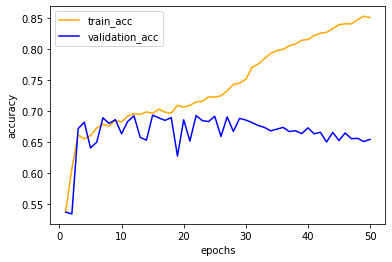

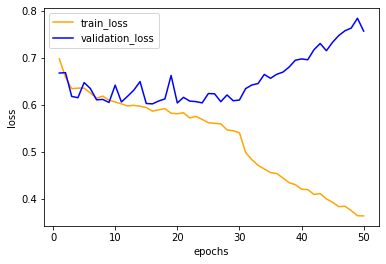

In [12]:
model.accuracy_curve()
model.loss_curve()

In [13]:
lab_train,pre_train,predict_train,acc_train = model.evaluate(train_loader,name='train')
print(acc_train)
lab_test,pre_test,predict_test,acc_test=model.evaluate(test_loader,name='test')
print(acc_test)
lab_valid,pre_valid,predict_valid,acc_valid=model.evaluate(validate_loader,name='valid')
print(acc_valid)


correct are 6631/8020
tensor(0.8268)
correct are 744/1146
tensor(0.6492)
correct are 1496/2286
tensor(0.6544)


[[3333  666]
 [ 723 3298]]
precision :  0.8319878910191726
recall :  0.8201939815966177


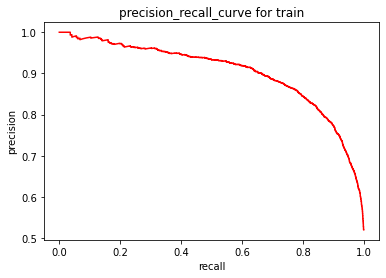

[[364 192]
 [210 380]]
precision :  0.6643356643356644
recall :  0.6440677966101694


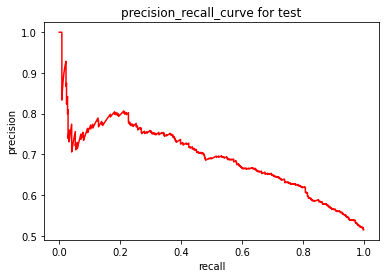

In [14]:
model.plot_precision_recall(lab_train,pre_train,predict_train,name='train')
model.plot_precision_recall(lab_test,pre_test,predict_test,name='test')

In [35]:
# der = 'saved_models/squeeze_1_0_cuda2_pretrained_classifier_1_conv2d_512_2_ker_1_stride_1_padding_0.pth'
# try:
#     torch.save({'best_model':squeeze_1_0.state_dict(),'best_optim':optimizer.state_dict()},der)
#     print('saved')
# except Exception as e:
#     print(e)

saved


In [16]:
# model.save_model()
# os.listdir(os.getcwd())
# squeeze_1_0 = torchvision.models.squeezenet1_0(pretrained=True)
# print(squeeze_1_0)
# mob_v2 = torchvision.models.mobilenet_v2(pretrained=True)
# print(mob_v2)

# squeezenet with some modification

In [17]:
squeeze_1_0 = torchvision.models.squeezenet1_0(pretrained=True)
squeeze_1_0.classifier[1] = nn.Conv2d(512,2,kernel_size=1,stride=1,padding=0)

In [42]:
squeeze_1_0.state_dict()

OrderedDict([('features.0.weight',
              tensor([[[[-8.3431e-03,  3.7170e-02,  6.0582e-02,  ..., -1.1278e-02,
                         -3.1725e-02, -4.0409e-02],
                        [-2.0415e-02,  4.2824e-02,  2.5232e-01,  ...,  1.1814e-01,
                          7.1244e-02,  9.0227e-03],
                        [-7.5023e-02, -1.4686e-01,  2.1004e-01,  ..., -5.7839e-02,
                          7.1742e-02, -5.0698e-02],
                        ...,
                        [ 5.4739e-02, -1.1365e-01,  2.2026e-01,  ..., -5.6963e-02,
                          2.0170e-01,  2.6866e-02],
                        [-1.9902e-02, -1.1130e-01,  4.3643e-02,  ..., -1.8514e-01,
                          3.6510e-02,  1.0653e-02],
                        [ 1.8800e-03, -2.9503e-02,  9.2201e-02,  ..., -7.8657e-02,
                          9.1456e-03, -8.8138e-04]],
              
                       [[-5.1776e-03,  5.0602e-02,  6.1997e-02,  ...,  9.9763e-03,
                          8

In [19]:
Losses_ = nn.CrossEntropyLoss()
lr = 3e-4
optimizer = optim.Adam(params=squeeze_1_0.parameters(),lr=lr)
schedular = optim.lr_scheduler.StepLR(optimizer,step_size=10,gamma=0.1)
n_epochs=50

model = Model_class(squeeze_1_0,gpu_id)
model.print_params()
print()
model.train(train_loader,optimizer,Losses_,lr,n_epochs,validate_loader,schedular)

total_trainable_parameters are : 736450

epoch:[1/50],memory:[1.5050435066223145/10.91650390625], lr:[0.0003]
train_accuracy:0.614930555460945, train_loss:0.6701621219279275
val_acc:0.6182820051908493,val_loss:0.6600255866845449

one of the best validation acc found
epoch:[2/50],memory:[1.5056495666503906/10.91650390625], lr:[0.0003]
train_accuracy:0.662227182634293, train_loss:0.6276474812674144
val_acc:0.6677611718575159,val_loss:0.6242208696073956

one of the best validation acc found
epoch:[3/50],memory:[1.5138964653015137/10.91650390625], lr:[0.0003]
train_accuracy:0.676661706633038, train_loss:0.6214291382403601
val_acc:0.675932216975424,val_loss:0.6153407345215479

epoch:[4/50],memory:[1.5138964653015137/10.91650390625], lr:[0.0003]
train_accuracy:0.6814236111111112, train_loss:0.6120618224617035
val_acc:0.6751396440797381,val_loss:0.61881975001759

epoch:[5/50],memory:[1.5138964653015137/10.91650390625], lr:[0.0003]
train_accuracy:0.678100198507309, train_loss:0.613618874360644

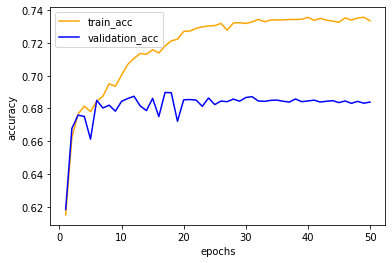

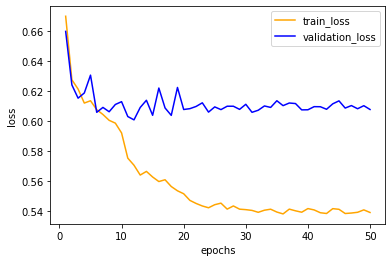

In [20]:
model.accuracy_curve()
model.loss_curve()

In [21]:
lab_train,pre_train,predict_train,acc_train = model.evaluate(train_loader,name='train')
print(acc_train)
lab_test,pre_test,predict_test,acc_test=model.evaluate(test_loader,name='test')
print(acc_test)
lab_valid,pre_valid,predict_valid,acc_valid=model.evaluate(validate_loader,name='valid')
print(acc_valid)

correct are 5839/8020
tensor(0.7281)
correct are 797/1146
tensor(0.6955)
correct are 1562/2286
tensor(0.6833)


In [39]:
# model.plot_roc(name='train')
# model.plot_roc(name='test')
# model.plot_roc(name='valid')
def plot_roc(color,name='test'): # name can be test train or validation
        plt.figure(figsize=(8,5))
        plt.plot(model.fpr[name],model.tpr[name],label=f"{name}:{model.auc_[name]}",color=color)
        plt.xlabel('fpr')
        plt.ylabel('tpr')
        plt.legend()
        plt.title(f'{name} ROC')
        plt.show()

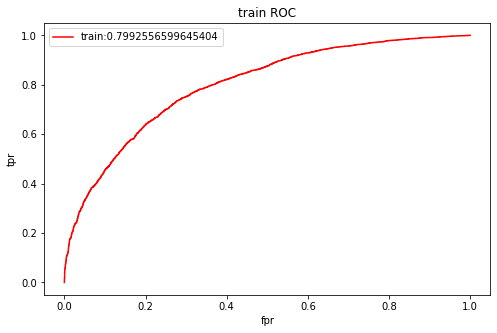

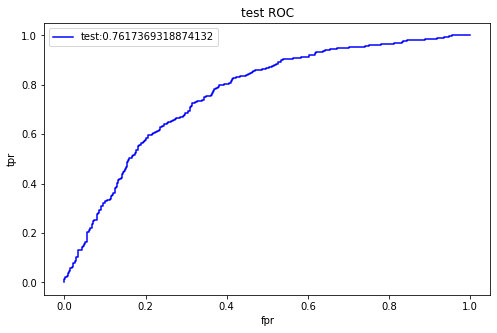

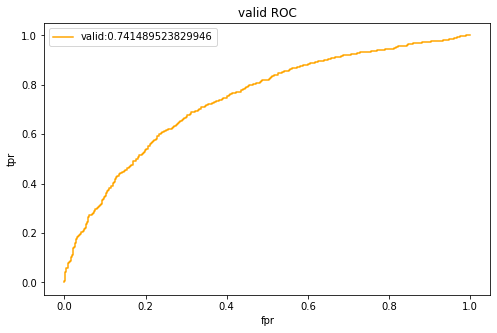

In [40]:
plot_roc(name='train',color='red')
plot_roc(name='test',color='blue')
plot_roc(name='valid',color='orange')

In [41]:
model.best_model

OrderedDict([('features.0.weight',
              tensor([[[[-7.5837e-03,  3.7677e-02,  6.0865e-02,  ..., -1.1053e-02,
                         -3.1532e-02, -4.0493e-02],
                        [-1.9755e-02,  4.3322e-02,  2.5262e-01,  ...,  1.1846e-01,
                          7.1483e-02,  8.9364e-03],
                        [-7.4507e-02, -1.4651e-01,  2.1025e-01,  ..., -5.7677e-02,
                          7.1810e-02, -5.0887e-02],
                        ...,
                        [ 5.4867e-02, -1.1362e-01,  2.2018e-01,  ..., -5.7145e-02,
                          2.0146e-01,  2.6530e-02],
                        [-1.9867e-02, -1.1141e-01,  4.3470e-02,  ..., -1.8548e-01,
                          3.6035e-02,  1.0137e-02],
                        [ 2.0538e-03, -2.9466e-02,  9.2153e-02,  ..., -7.9169e-02,
                          8.5289e-03, -1.4774e-03]],
              
                       [[-4.4182e-03,  5.1109e-02,  6.2280e-02,  ...,  1.0201e-02,
                          8

In [43]:
message = {'pretrained':True,
          'classifier_1':'conv2d(512,2,ker=1,stri=1,pad=0)',
          'cuda':2,
          'train':72,
          'test':69.5,
          'valid':68}
model.save_model('saved_models/squeeze_1_0_best_model.pth',message)

model saved


In [44]:
try:
    torch.save({'model':squeeze_1_0.state_dict(),'message':message},'saved_models/squeeze_1_0_test_69.5_auc_76.pth')
    print('saved')
except Exception as e:
    print(e)
    

saved


In [2]:
squeeze_1_0 = torchvision.models.squeezenet1_0(pretrained=True)
print(squeeze_1_0)
mob_v2 = torchvision.models.mobilenet_v2(pretrained=True)
print(mob_v2)

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): Fire(
   